In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import rbf_kernel

data = load_iris()

X_full = data.data
y = data.target
print(f"original shape: {X_full.shape}, classes: {np.unique(y)}")

original shape: (150, 4), classes: [0 1 2]


In [15]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(StandardScaler().fit_transform(X_full))
print("Explained variance ratio by 2 PCA components:", pca.explained_variance_ratio_)

# Standardize the 2D projected features
scaler = StandardScaler()
X = scaler.fit_transform(X_2d)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y)


def plot_decision_regions(clf, X_train, y_train, title, is_precomputed=False, gamma_pre=None):
    # grid
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]

    if is_precomputed:
        if gamma_pre is None:
            raise ValueError("gamma_pre must be provided for precomputed kernel plotting")
        K_grid = rbf_kernel(grid, X_train, gamma=gamma_pre)  # shape: (n_grid, n_train)
        Z = clf.predict(K_grid)
    else:
        Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, alpha=0.3)          # predicted class regions
    plt.contour(xx, yy, Z, levels=np.unique(Z), linewidths=0.3, alpha=0.7)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', s=30)
    # support vectors — for precomputed kernel use indices in clf.support_
    sv = clf.support_vectors_ if not is_precomputed else X_train[clf.support_]
    plt.scatter(sv[:, 0], sv[:, 1], facecolors='none', edgecolors='k',
                s=80, linewidths=1.2, label='Support Vectors')
    plt.title(title)
    plt.xlabel('PCA component 1 (standardized)')
    plt.ylabel('PCA component 2 (standardized)')
    plt.legend()
    plt.tight_layout()
    plt.show()

Explained variance ratio by 2 PCA components: [0.72962445 0.22850762]


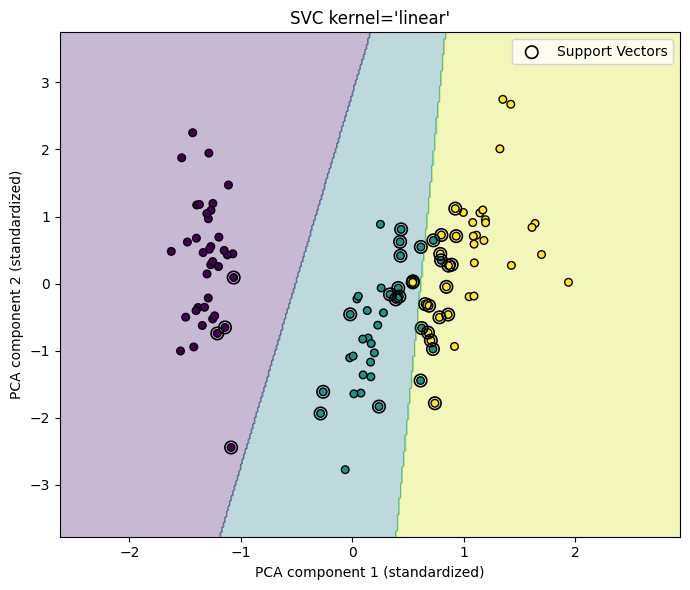

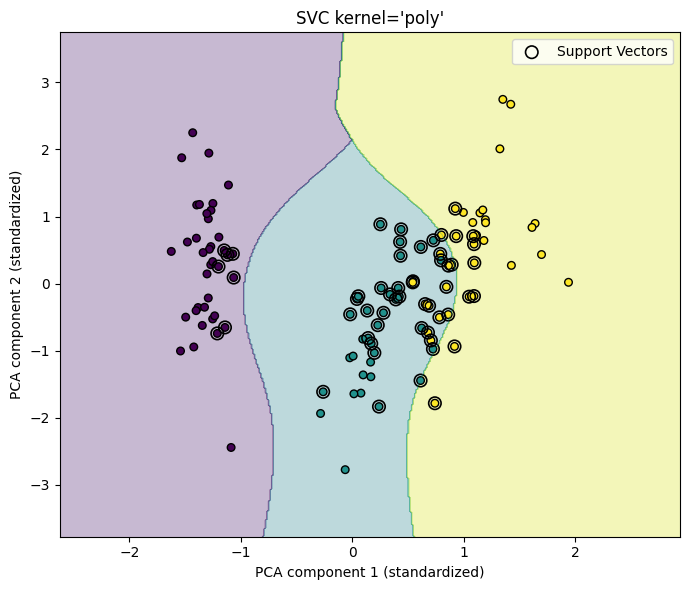

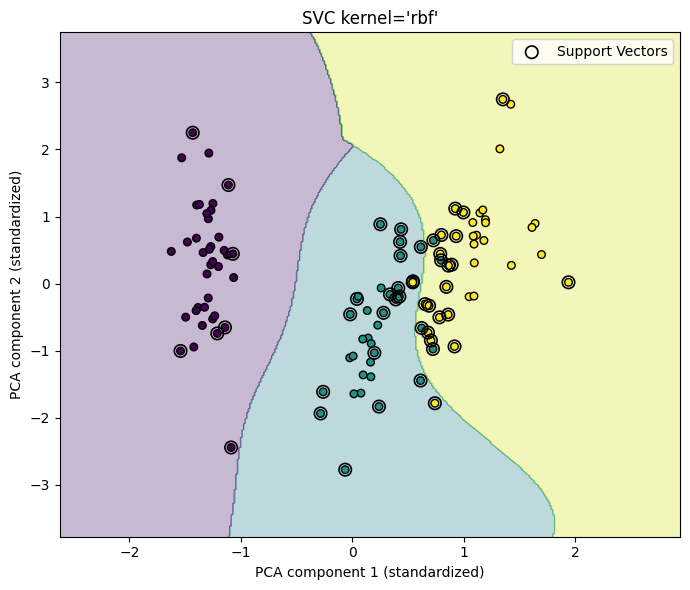

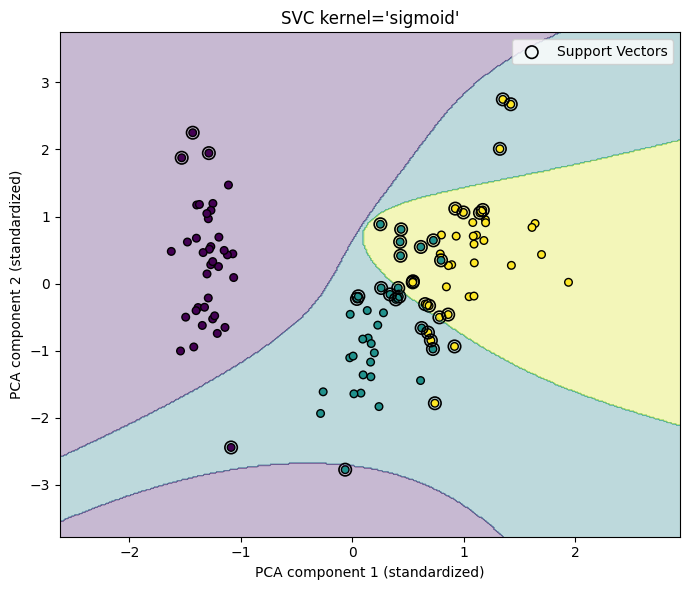

In [16]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = []

for kernel in kernels:

        if kernel == 'poly':
            clf = SVC(kernel='poly', degree=3, gamma='scale', C=1.0, decision_function_shape='ovr')
        else:
            clf = SVC(kernel=kernel, gamma='scale', C=1.0, decision_function_shape='ovr')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append({'kernel': kernel, 'accuracy': acc, 'report': report, 'clf': clf})
        plot_decision_regions(clf, X_train, y_train, f"SVC kernel='{kernel}'", is_precomputed=False)

In [17]:

summary_rows = []
for r in results:
    k = r['kernel']
    acc = r['accuracy']
    macro_f1 = r['report'].get('macro avg', {}).get('f1-score', None)
    summary_rows.append({
        'Kernel': k,
        'Accuracy': round(acc,4),
        'Macro_F1': round(macro_f1,4) if macro_f1 is not None else None
    })

summary_df = pd.DataFrame(summary_rows).sort_values('Accuracy', ascending=False).reset_index(drop=True)
print("\nSVC kernel comparison summary:\n")
print(summary_df.to_string(index=False))
# Optionally save
summary_df.to_csv("svm_kernel_sklearn_dataset_summary.csv", index=False)
print("\nSaved summary to 'svm_kernel_sklearn_dataset_summary.csv'.")


SVC kernel comparison summary:

 Kernel  Accuracy  Macro_F1
   poly    0.8421    0.8424
    rbf    0.8421    0.8462
 linear    0.8158    0.8202
sigmoid    0.7368    0.7421

Saved summary to 'svm_kernel_sklearn_dataset_summary.csv'.
